# 01-Data_Exploration

In [2]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.7 MB/s eta 0:00:

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:10<00:30, 10.12s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:17<00:16,  8.25s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:23<00:07,  7.40s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:29<00:00,  7.47s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [9]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:06<00:06,  3.14s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:09<00:03,  3.10s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [10]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [11]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [12]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:07<00:00,  7.05s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [13]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [14]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [17]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
# Model Poisoning Attack
print("--- Defining Model Poisoning Attack ---")
num_malicious_clients = 3  # about 10% of 33 clients
# Note: client_fn creates clients with string IDs, so we create a list of strings
malicious_client_ids = [str(i) for i in range(num_malicious_clients)]
poison_factor = 3.0 # Amplify weights to overpower other clients. A negative value could be used to flip the weights.

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Scaling weights by a factor of {poison_factor} for malicious clients after local training.")
print("--- Model Poisoning Attack Defined ---")


--- Defining Model Poisoning Attack ---
Poisoning 3 clients: ['0', '1', '2']
Scaling weights by a factor of 3.0 for malicious clients after local training.
--- Model Poisoning Attack Defined ---


In [19]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
6     12985
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  6 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8  0 33 26 22 12 21
  9 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
6     12985
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16    

Visualize Data Distribution

STRATIFIED Client

In [20]:
#STRATIFIED Client

In [21]:
#LEAVE_ONE_OUT

In [22]:
#Half begign

In [23]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


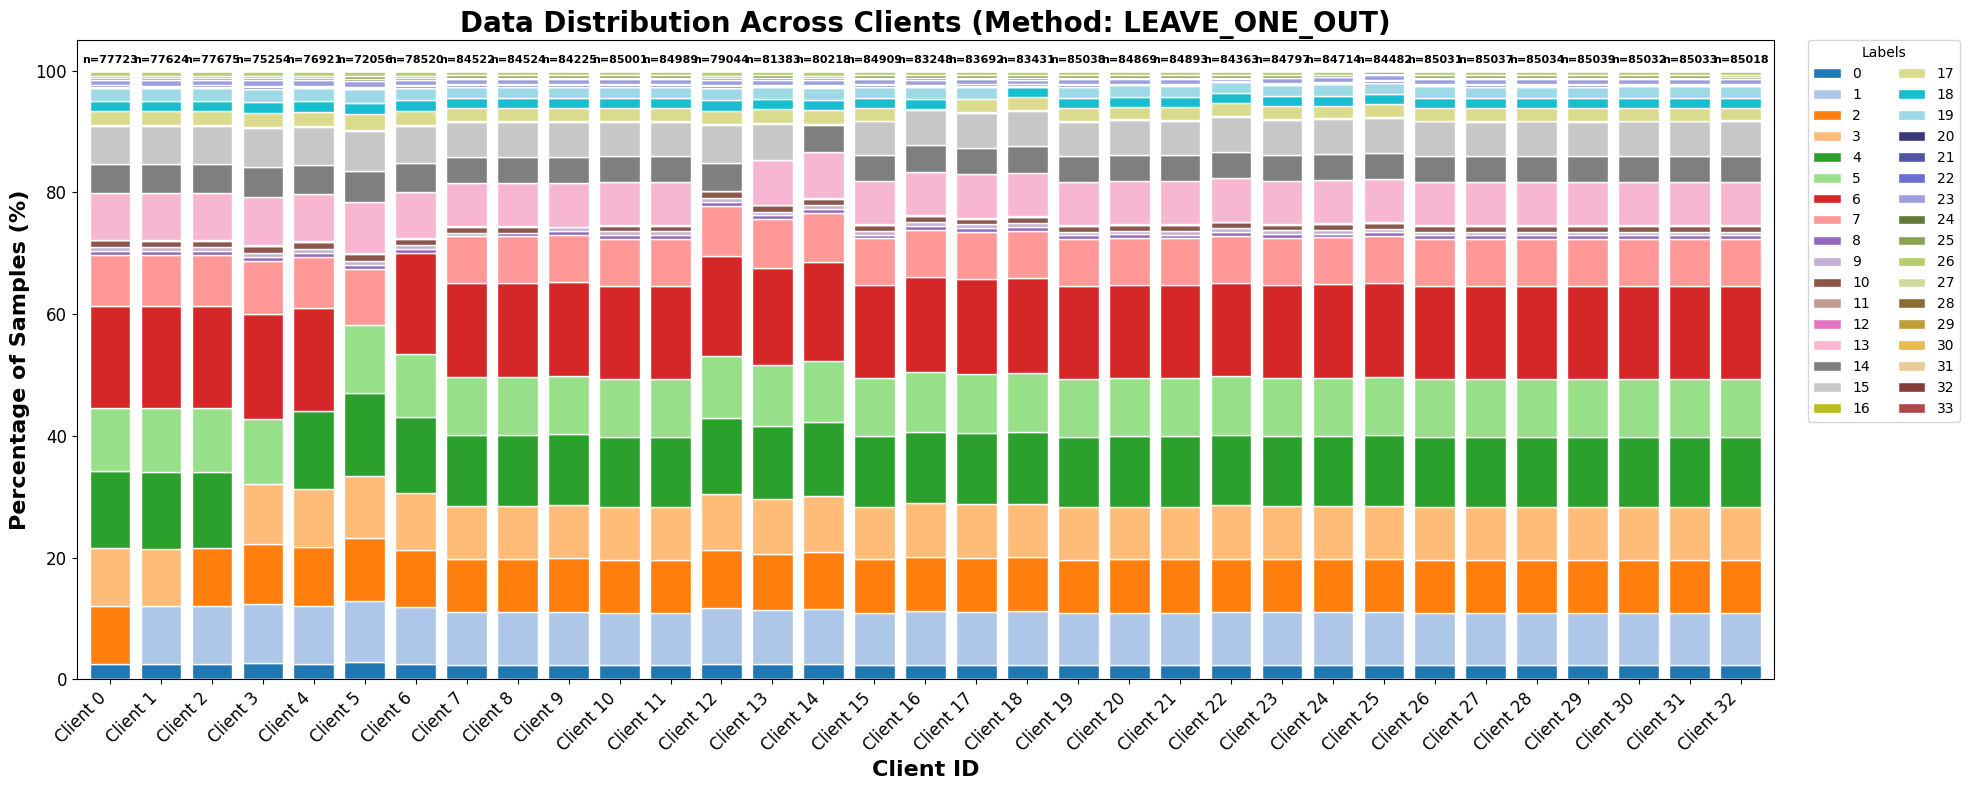

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [25]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [26]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [27]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [28]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [29]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [30]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [31]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)
        print ("Client ", self.cid, "Training complete...")

        weights = self.model.get_weights()

        # If the client is in the malicious list, poison the weights
        if self.cid in malicious_client_ids:
            print(f"Client {self.cid} is malicious, applying model poisoning...")
            poisoned_weights = [w * poison_factor for w in weights]
            return poisoned_weights, len(self.train_data), {}

        return weights, len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [32]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10, #10,
        min_evaluate_clients=5, #5,
        min_available_clients=10, #10,
        evaluate_fn=get_evaluate_fn(server_model),
        #evaluate_metrics_aggregation_fn=weighted_average,
)
# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-10 08:32:00,983	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7941695079.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3970847539.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1756) WARNING: All log messages before absl::InitializeLog() 

(ClientAppActor pid=1757) Client ID: 3
Server Evaluating... Evaluation Count: 0
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.1601 - loss: 3.4486
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
Prediction:  [[0.02606751 0.0483269  0.02284499 ... 0.01286032 0.03004982 0.04765764]
 [0.01604603 0.0501122  0.02762551 ... 0.01181615 0.02093092 0.03233821]
 [0.03173518 0.03207909 0.02685863 ... 0.02162477 0.02551705 0.02713825]
 ...
 [0.01318451 0.04348907 0.01969071 ... 0.01002704 0.02812449 0.01180181]
 [0.02573406 0.03524573 0.02726963 ... 0.02479634 0.03143362 0.02756385]
 [0.02649903 0.03453724 0.02749445 ... 0.02560521 0.03137171 0.02867505]] (744790, 34)
Server evaluation complete - Accuracy: 0.1608, Loss: 3.4486


INFO :      initial parameters (loss, other metrics): 3.4485766887664795, {'accuracy': 0.1608399748802185}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)
(ClientAppActor pid=1757) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1757) 
(ClientAppActor pid=1757)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1757)             entirely in future versions of Flower.
(ClientAppActor pid=1757)         
(ClientAppActor pid=1757) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(Clie

(ClientAppActor pid=1757) Client ID: 29
(ClientAppActor pid=1757) Client  29 Training...


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1756) Client ID: 24
(ClientAppActor pid=1757) Epoch 1/5
  15/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1584 - loss: 3.3850    
  52/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2694 - loss: 3.1494
  86/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3319 - loss: 2.9383
 813/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6100 - loss: 1.3852
 866/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6152 - loss: 1.3517
 982/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6250 - loss: 1.2880
(ClientAppActor pid=1756) Client  24 Training...
 992/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6257 - loss: 1.2831
(ClientAppActor pid=1756) Epoch 1/5
1131/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6351 - loss: 1.2211
1143/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6358 - loss: 1.2163
1275/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6430 - loss: 1.1680
  17/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1849 - l

(ClientAppActor pid=1757) 
(ClientAppActor pid=1757)         
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1757) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1757)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1757)             entirely in future versions of Flower.
(ClientAppActor pid=1757) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1757) Client  7 Training...
(ClientAppActor pid=1757) Epoch 1/5


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  13/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1969 - loss: 3.3901   
2648/2648 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7485 - loss: 0.4809 [repeated 5x across cluster]
  44/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2775 - loss: 3.2156
(ClientAppActor pid=1756) Client  24 Training complete...
  83/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3416 - loss: 2.9918
 108/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3756 - loss: 2.8474
 127/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3985 - loss: 2.7430
  62/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3098 - loss: 3.1136 [repeated 8x across cluster]
 141/2642 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4136 - loss: 2.6706
(ClientAppActor pid=1756) Client ID: 8
(ClientAppActor pid=1756) Client  8 Training...
(ClientAppActor pid=1756) Epoch 1/5
 642/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5986 - loss: 1.5441
  10/2642 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.

(ClientAppActor pid=1757) 
(ClientAppActor pid=1757)         
(ClientAppActor pid=1757) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1757) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1757)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1757)             entirely in future versions of Flower.
(ClientAppActor pid=1757) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

   5/2426 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.1740 - loss: 3.3969  
(ClientAppActor pid=1756) Client  8 Training complete...
2636/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7449 - loss: 0.4937 [repeated 5x across cluster]
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7449 - loss: 0.4937
(ClientAppActor pid=1756) Client ID: 1
(ClientAppActor pid=1756) Client  1 Training...
(ClientAppActor pid=1756) Epoch 1/5
  11/2426 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.2073 - loss: 3.3655
  15/2426 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.2201 - loss: 3.3467
  24/2426 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.2502 - loss: 3.2944
  34/2426 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.2809 - loss: 3.2344


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  38/2426 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.2920 - loss: 3.2088
  51/2426 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.3213 - loss: 3.1263


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  61/2426 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.3376 - loss: 3.0663
  72/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.3543 - loss: 2.9982
  85/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.3724 - loss: 2.9191
  90/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.3790 - loss: 2.8889
 107/2426 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.3992 - loss: 2.7898
 112/2426 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.4046 - loss: 2.7620
 117/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.4098 - loss: 2.7346
 126/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.4187 - loss: 2.6868
 141/2426 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.4324 - loss: 2.6101
 149/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.4390 - loss: 2.5712
 165/2426 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.4511 - loss: 2.4976
 179/2426 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.4608 - loss: 2.4371


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 184/2426 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.4640 - loss: 2.4164


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 188/2426 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.4666 - loss: 2.4002
 211/2426 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.4802 - loss: 2.3125
 227/2426 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.4887 - loss: 2.2567
 253/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.5012 - loss: 2.1745
 258/2426 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.5034 - loss: 2.1599


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 267/2426 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.5073 - loss: 2.1342
 297/2426 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.5191 - loss: 2.0553
 329/2426 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.5299 - loss: 1.9808
 355/2426 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5375 - loss: 1.9264
 391/2426 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5468 - loss: 1.8590
 425/2426 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5544 - loss: 1.8023 
 462/2426 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.5618 - loss: 1.7468
 491/2426 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5670 - loss: 1.7072
 534/2426 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5739 - loss: 1.6542
 574/2426 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5797 - loss: 1.6098
 618/2426 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5853 - loss: 1.5657
 655/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5895 - loss: 1.5319
 700/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.

(raylet) [2025-09-10 08:37:00,949 E 1580 1580] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 2a6986e9b6e68b121f94b8fd664065def5ccfabb1b58630a21ad03f8, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, 

1014/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7199 - loss: 0.5519
1071/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7199 - loss: 0.5519
1120/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7198 - loss: 0.5518
1171/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7198 - loss: 0.5518
1231/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7199 - loss: 0.5517
1288/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7199 - loss: 0.5516
1347/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7199 - loss: 0.5515
1403/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7199 - loss: 0.5514
1463/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7198 - loss: 0.5513
1518/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7198 - loss: 0.5512
1571/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7199 - loss: 0.5512
1625/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7199 - loss: 0.5511
1683/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7199 - loss: 0.5511

INFO :      aggregate_fit: received 5 results and 28 failures


2334/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7245 - loss: 0.5350
2389/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7245 - loss: 0.5350
Server Evaluating... Evaluation Count: 1
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7244 - loss: 0.5350
(ClientAppActor pid=1756) Client  1 Training complete...
(ClientAppActor pid=1756) Client 1 is malicious, applying model poisoning...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.6471 - loss: 1.1382
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step


INFO :      fit progress: (1, 1.139504313468933, {'accuracy': 0.6468467712402344}, 235.09093033900007)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[4.87065520e-13 1.96983407e-13 2.55368279e-15 ... 1.24370281e-21
  5.75915568e-17 1.23957893e-11]
 [4.19085460e-08 1.02724523e-10 2.54650193e-04 ... 3.09748531e-14
  4.56024888e-12 5.69141401e-10]
 [1.06832645e-15 2.48691313e-13 1.01851295e-17 ... 2.22585999e-24
  2.66166504e-27 1.14317097e-19]
 ...
 [3.80594095e-14 1.50222344e-14 1.04216398e-23 ... 4.34400796e-30
  1.10000018e-18 2.32178822e-20]
 [1.32747058e-13 6.39218171e-13 3.33271234e-17 ... 7.60621773e-18
  2.40517707e-22 6.00710935e-17]
 [1.97906383e-12 1.16498000e-11 5.42581830e-16 ... 2.82819166e-16
  5.91697414e-20 1.35291406e-15]] (744790, 34)
Server evaluation complete - Accuracy: 0.6468, Loss: 1.1395


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1756) Client ID: 26
(ClientAppActor pid=1756) Client  26 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:06:10 1s/step - accuracy: 0.7812 - loss: 1.1213
  12/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6549 - loss: 1.2322


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  20/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.6477 - loss: 1.2270
  33/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.6463 - loss: 1.2015


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  42/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6466 - loss: 1.1987
  45/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.6467 - loss: 1.1998


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  58/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6474 - loss: 1.1958
  73/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6491 - loss: 1.1894
  88/2658 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6498 - loss: 1.1847
  97/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6498 - loss: 1.1828
 114/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6494 - loss: 1.1802 
 124/2658 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6489 - loss: 1.1797


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 140/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6486 - loss: 1.1783 
 153/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6484 - loss: 1.1763
 166/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6484 - loss: 1.1745


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 171/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6484 - loss: 1.1742
 180/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6482 - loss: 1.1740
 198/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6479 - loss: 1.1735
 252/2658 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6475 - loss: 1.1730
 330/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6466 - loss: 1.1728
 400/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6461 - loss: 1.1702
 476/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6459 - loss: 1.1656
 543/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6460 - loss: 1.1623
 620/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6460 - loss: 1.1599
 654/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6460 - loss: 1.1591
 717/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6459 - loss: 1.1576
 750/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6459 - loss: 1.1569
 843/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6460 - loss:

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2627/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6467 - loss: 1.1444
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6467 - loss: 1.1445
(ClientAppActor pid=1756) Client 26 evaluation complete - Accuracy: 0.647046, Loss: 1.152544


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1756) Client ID: 14
(ClientAppActor pid=1756) Client  14 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=1756) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2507 ━━━━━━━━━━━━━━━━━━━━ 6:32:17 9s/step - accuracy: 0.7188 - loss: 0.6155
  29/2507 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7245 - loss: 0.7903
  89/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7534 - loss: 0.6391
 137/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7611 - loss: 0.5942
 190/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7658 - loss: 0.5666
 242/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7697 - loss: 0.5474
 298/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7728 - loss: 0.5337
 347/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7748 - loss: 0.5244
 407/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7769 - loss: 0.5152
 456/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7780 - loss: 0.5092
 508/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7790 - loss: 0.5037
 531/2507 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7793 - loss: 0.5015
 580/2507 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7800 - loss: 0.

INFO :      aggregate_fit: received 1 results and 32 failures


2399/2507 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.3966
2451/2507 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.3966
Server Evaluating... Evaluation Count: 2
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8054 - loss: 0.3966
(ClientAppActor pid=1756) Client  14 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.7541 - loss: 1.2943
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[1.1885401e-05 2.3566469e-07 1.0091368e-05 ... 6.8897409e-11
  1.6313602e-09 8.6389457e-07]
 [1.6785274e-08 2.3468413e-12 9.9999553e-01 ... 4.0648925e-18
  3.3243738e-16 2.4926753e-14]
 [9.2492796e-09 1.1424622e-05 2.1462164e-07 ... 1.2529991e-23
  2.8554176e-21 1.6588142e-16]
 ...
 [7.2236833e-10 2.9485779e-14 2.8966429e-10 ... 2.0586800e-24
  8.8962904e-17 1.3425908e-17]
 [2.7972044e-10 4.8223620e-10 5.0698740e-11 ... 1.5014424e-21
  4.6707257e-20 6.3650423e-18]
 [3.6645398e-09 1.7342126e-08 2.6254843e-10 ... 8.4178991e-20

INFO :      fit progress: (2, 1.2945021390914917, {'accuracy': 0.7542595863342285}, 446.317980073)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7543, Loss: 1.2945


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_t

(ClientAppActor pid=1756) Client ID: 20


(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1756) Client  20 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   3/2653 ━━━━━━━━━━━━━━━━━━━━ 1:07 25ms/step - accuracy: 0.7431 - loss: 1.8382 
  14/2653 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7769 - loss: 1.3493


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  25/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.7894 - loss: 1.2422
  35/2653 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7928 - loss: 1.2134


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  46/2653 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7940 - loss: 1.2077
  57/2653 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.7922 - loss: 1.2169
  92/2653 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7869 - loss: 1.2167 
 152/2653 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7803 - loss: 1.2202
 225/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7750 - loss: 1.2258 
 257/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7732 - loss: 1.2270
 328/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7706 - loss: 1.2265
 385/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7695 - loss: 1.2280
 453/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7682 - loss: 1.2317
 519/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7671 - loss: 1.2326
 584/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7662 - loss: 1.2340
 657/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7653 - loss: 1.2347
 719/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7646 - loss

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2604/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7582 - loss: 1.2540
2640/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7582 - loss: 1.2543
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7582 - loss: 1.2544
(ClientAppActor pid=1756) Client 20 evaluation complete - Accuracy: 0.754751, Loss: 1.279116


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1756) Client ID: 28
(ClientAppActor pid=1756) Client  28 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=1756) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 4:33:35 6s/step - accuracy: 0.6250 - loss: 2.1335
   3/2658 ━━━━━━━━━━━━━━━━━━━━ 1:34 35ms/step - accuracy: 0.6667 - loss: 1.6128 
   7/2658 ━━━━━━━━━━━━━━━━━━━━ 1:37 37ms/step - accuracy: 0.6910 - loss: 1.3880
  10/2658 ━━━━━━━━━━━━━━━━━━━━ 1:23 32ms/step - accuracy: 0.6968 - loss: 1.3526
  16/2658 ━━━━━━━━━━━━━━━━━━━━ 1:15 29ms/step - accuracy: 0.7055 - loss: 1.3209
  18/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18 30ms/step - accuracy: 0.7081 - loss: 1.3092
  23/2658 ━━━━━━━━━━━━━━━━━━━━ 1:19 30ms/step - accuracy: 0.7136 - loss: 1.2829
  25/2658 ━━━━━━━━━━━━━━━━━━━━ 1:19 30ms/step - accuracy: 0.7146 - loss: 1.2795
  31/2658 ━━━━━━━━━━━━━━━━━━━━ 1:14 28ms/step - accuracy: 0.7177 - loss: 1.2580
  32/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18 30ms/step - accuracy: 0.7183 - loss: 1.2531


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  37/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18 30ms/step - accuracy: 0.7204 - loss: 1.2322
  44/2658 ━━━━━━━━━━━━━━━━━━━━ 1:12 28ms/step - accuracy: 0.7230 - loss: 1.2038


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  47/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18 30ms/step - accuracy: 0.7238 - loss: 1.1922
  48/2658 ━━━━━━━━━━━━━━━━━━━━ 1:19 31ms/step - accuracy: 0.7240 - loss: 1.1886
  50/2658 ━━━━━━━━━━━━━━━━━━━━ 1:22 31ms/step - accuracy: 0.7243 - loss: 1.1816
  51/2658 ━━━━━━━━━━━━━━━━━━━━ 1:26 33ms/step - accuracy: 0.7245 - loss: 1.1781


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  54/2658 ━━━━━━━━━━━━━━━━━━━━ 1:25 33ms/step - accuracy: 0.7252 - loss: 1.1677
  55/2658 ━━━━━━━━━━━━━━━━━━━━ 1:31 35ms/step - accuracy: 0.7254 - loss: 1.1643


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  56/2658 ━━━━━━━━━━━━━━━━━━━━ 1:33 36ms/step - accuracy: 0.7257 - loss: 1.1610
  60/2658 ━━━━━━━━━━━━━━━━━━━━ 1:33 36ms/step - accuracy: 0.7268 - loss: 1.1481


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 2a6986e9b6e68b121f94b8fd664065def5ccfabb1b58630a21ad03f8) where the task (actor ID: 4942cb473c0f0b3ffd2df3bf01000000, name=ClientAppActor.__init__, pid=1757, memory used=0.42GB) was running was 12.13GB / 12.67GB (0.957001), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 74d6af0d4f21c15e47cfddfcc0c9b6c78b5a18f88fa67a4b60406b44) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-74d6af0d4f21c15e47cfddfcc0c9b6c78b5a18f88fa67a4b60406b44*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
334	9.56	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-a9191ed3-964d...
1756	0.43	ray::ClientAppActor.run
1757	0.42	ray::ClientAppActor.run
1013	0.29	node /datalab/web/pyr

  64/2658 ━━━━━━━━━━━━━━━━━━━━ 1:33 36ms/step - accuracy: 0.7278 - loss: 1.1353
  65/2658 ━━━━━━━━━━━━━━━━━━━━ 1:33 36ms/step - accuracy: 0.7281 - loss: 1.1321


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  67/2658 ━━━━━━━━━━━━━━━━━━━━ 1:33 36ms/step - accuracy: 0.7285 - loss: 1.1260
  70/2658 ━━━━━━━━━━━━━━━━━━━━ 1:32 36ms/step - accuracy: 0.7291 - loss: 1.1173
  71/2658 ━━━━━━━━━━━━━━━━━━━━ 1:34 37ms/step - accuracy: 0.7293 - loss: 1.1145
  76/2658 ━━━━━━━━━━━━━━━━━━━━ 1:30 35ms/step - accuracy: 0.7301 - loss: 1.1006
  78/2658 ━━━━━━━━━━━━━━━━━━━━ 1:33 36ms/step - accuracy: 0.7304 - loss: 1.0951
  84/2658 ━━━━━━━━━━━━━━━━━━━━ 1:27 34ms/step - accuracy: 0.7313 - loss: 1.0792


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  93/2658 ━━━━━━━━━━━━━━━━━━━━ 1:24 33ms/step - accuracy: 0.7328 - loss: 1.0566
 112/2658 ━━━━━━━━━━━━━━━━━━━━ 1:11 28ms/step - accuracy: 0.7358 - loss: 1.0125
 130/2658 ━━━━━━━━━━━━━━━━━━━━ 1:03 25ms/step - accuracy: 0.7380 - loss: 0.9763
 164/2658 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.7410 - loss: 0.9201
 199/2658 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7424 - loss: 0.8760
 232/2658 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7433 - loss: 0.8425
 260/2658 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7438 - loss: 0.8191
 286/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7441 - loss: 0.8004
 321/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7443 - loss: 0.7788
 354/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7445 - loss: 0.7611
 392/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7448 - loss: 0.7433
 423/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7452 - loss: 0.7304
 454/2658 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - acc

INFO :      aggregate_fit: received 1 results and 32 failures


2633/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7684 - loss: 0.4512
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7684 - loss: 0.4512
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7684 - loss: 0.4512
Server Evaluating... Evaluation Count: 3
(ClientAppActor pid=1756) Client  28 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7668 - loss: 0.4695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[4.2498136e-06 2.2571987e-08 2.1385440e-05 ... 3.8386833e-10
  4.3400439e-10 3.6395276e-09]
 [2.9790241e-08 8.1789459e-16 9.9998993e-01 ... 1.0612107e-17
  4.2946935e-14 1.0296939e-12]
 [8.2013635e-10 5.0496450e-08 4.7000764e-08 ... 1.8686618e-24
  2.9704362e-23 1.5105615e-15]
 ...
 [1.9872306e-09 1.1782665e-13 3.0848590e-09 ... 2.2036743e-20
  1.1492752e-15 5.2055816e-17]
 [1.4457813e-05 3.4303755e-06 1.0868695e-06 ... 3.0462194e-13
  8.9979640e-10 1.4244677e-09]
 [4.0006245e-05 1.9559782e-05 4.3065434e-06 ... 7.1780329e-12

INFO :      fit progress: (3, 0.4703623950481415, {'accuracy': 0.7669786214828491}, 624.2245993019999)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7670, Loss: 0.4704


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1756) Client ID: 2


(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1756) Client  2 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   5/2428 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7539 - loss: 0.5345  
  14/2428 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7675 - loss: 0.4882
  25/2428 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7720 - loss: 0.4709
  30/2428 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7751 - loss: 0.4632


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  33/2428 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7769 - loss: 0.4588
  40/2428 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7800 - loss: 0.4519


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  41/2428 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.7804 - loss: 0.4511
  44/2428 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.7813 - loss: 0.4487
  49/2428 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7826 - loss: 0.4451
  53/2428 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.7832 - loss: 0.4428
  55/2428 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7835 - loss: 0.4418
  61/2428 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.7840 - loss: 0.4404
  65/2428 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7841 - loss: 0.4404


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  69/2428 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.7843 - loss: 0.4402
  71/2428 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.7845 - loss: 0.4401
  76/2428 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.7849 - loss: 0.4397
  79/2428 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.7850 - loss: 0.4395


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  82/2428 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.7851 - loss: 0.4393
  87/2428 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.7853 - loss: 0.4392


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  93/2428 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.7854 - loss: 0.4389
 102/2428 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.7857 - loss: 0.4385
 105/2428 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.7858 - loss: 0.4384
 114/2428 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.7858 - loss: 0.4386
 119/2428 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accuracy: 0.7859 - loss: 0.4387
 122/2428 ━━━━━━━━━━━━━━━━━━━━ 1:00 26ms/step - accuracy: 0.7859 - loss: 0.4387
 191/2428 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.7854 - loss: 0.4427
 232/2428 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.7855 - loss: 0.4426
 276/2428 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.7858 - loss: 0.4419
 321/2428 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7860 - loss: 0.4405
 366/2428 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7864 - loss: 0.4389
 410/2428 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7865 - loss: 0.4379 
 446/2428 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accur

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2370/2428 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7879 - loss: 0.4284
2397/2428 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7879 - loss: 0.4284
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7879 - loss: 0.4284
(ClientAppActor pid=1756) Client 2 evaluation complete - Accuracy: 0.787023, Loss: 0.430212


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1756) Client ID: 24


(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1756) Client  24 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=1756) Epoch 1/5


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 2a6986e9b6e68b121f94b8fd664065def5ccfabb1b58630a21ad03f8) where the task (actor ID: 4942cb473c0f0b3ffd2df3bf01000000, name=ClientAppActor.__init__, pid=1757, memory used=0.42GB) was running was 12.13GB / 12.67GB (0.957001), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 74d6af0d4f21c15e47cfddfcc0c9b6c78b5a18f88fa67a4b60406b44) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-74d6af0d4f21c15e47cfddfcc0c9b6c78b5a18f88fa67a4b60406b44*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
334	9.56	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-a9191ed3-964d...
1756	0.43	ray::ClientAppActor.run
1757	0.42	ray::ClientAppActor.run
1013	0.29	node /datalab/web/pyr

   9/2648 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7207 - loss: 0.4926   
  14/2648 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7324 - loss: 0.4792
  16/2648 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.7356 - loss: 0.4759
  19/2648 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.7374 - loss: 0.4753
  27/2648 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.7425 - loss: 0.4747
  37/2648 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7444 - loss: 0.4779
  52/2648 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7478 - loss: 0.4782
  56/2648 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7488 - loss: 0.4773
  61/2648 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7498 - loss: 0.4762
  76/2648 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.7525 - loss: 0.4729
  79/2648 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7530 - loss: 0.4725
  91/2648 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7545 - loss: 0.4710


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 102/2648 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7558 - loss: 0.4698
 110/2648 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7569 - loss: 0.4687
 119/2648 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7581 - loss: 0.4676
 122/2648 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7584 - loss: 0.4674


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 123/2648 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7585 - loss: 0.4673
 136/2648 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7596 - loss: 0.4662


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 139/2648 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7599 - loss: 0.4659
 143/2648 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.7602 - loss: 0.4655
 152/2648 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7610 - loss: 0.4647
 155/2648 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7612 - loss: 0.4645
 159/2648 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7615 - loss: 0.4642
 160/2648 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7616 - loss: 0.4641


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 166/2648 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7619 - loss: 0.4637
 180/2648 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7628 - loss: 0.4627
 186/2648 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7631 - loss: 0.4623
 188/2648 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7633 - loss: 0.4622


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 192/2648 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.7635 - loss: 0.4620
 195/2648 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7636 - loss: 0.4619
 213/2648 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7644 - loss: 0.4610
 248/2648 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7654 - loss: 0.4596
 276/2648 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7661 - loss: 0.4590
 297/2648 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7664 - loss: 0.4586
 330/2648 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7669 - loss: 0.4581
 364/2648 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7673 - loss: 0.4576
 401/2648 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7677 - loss: 0.4572
 435/2648 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7679 - loss: 0.4569
 469/2648 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7681 - loss: 0.4566
 501/2648 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7682 - loss: 0.4563
 533/2648 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy:

INFO :      aggregate_fit: received 1 results and 32 failures


2564/2648 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.4407
2611/2648 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.4408
Server Evaluating... Evaluation Count: 4
2648/2648 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7723 - loss: 0.4408
(ClientAppActor pid=1756) Client  24 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7671 - loss: 0.5026
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[8.4068057e-07 1.2920401e-09 1.7504661e-05 ... 4.1578754e-12
  4.8551922e-12 5.2371860e-11]
 [1.5385394e-09 6.0779414e-13 9.9983072e-01 ... 2.0106461e-19
  3.2273159e-18 7.5728933e-14]
 [2.7813654e-09 8.9830769e-07 8.9173219e-10 ... 2.6566765e-24
  4.9705556e-27 3.2583121e-14]
 ...
 [1.4397968e-10 9.8162511e-16 1.1574190e-10 ... 1.0252630e-23
  3.6998278e-22 1.6021142e-19]
 [2.0075202e-06 7.4652712e-07 3.1547440e-08 ... 5.9403342e-16
  2.3200468e-16 4.1134527e-13]
 [1.0541564e-05 5.2432781e-05 3.3825586e-07 ... 1.4398660e-13

INFO :      fit progress: (4, 0.5032361745834351, {'accuracy': 0.7669410109519958}, 839.0106832409999)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7669, Loss: 0.5032


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1756) Client ID: 32
(ClientAppActor pid=1756) Client  32 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2657 ━━━━━━━━━━━━━━━━━━━━ 1:21:28 2s/step - accuracy: 0.7812 - loss: 0.4498
   2/2657 ━━━━━━━━━━━━━━━━━━━━ 6:12 140ms/step - accuracy: 0.7656 - loss: 0.4544
   3/2657 ━━━━━━━━━━━━━━━━━━━━ 6:19 143ms/step - accuracy: 0.7674 - loss: 0.4460
   4/2657 ━━━━━━━━━━━━━━━━━━━━ 6:52 155ms/step - accuracy: 0.7708 - loss: 0.4758
  16/2657 ━━━━━━━━━━━━━━━━━━━━ 1:45 40ms/step - accuracy: 0.7815 - loss: 0.4962
  33/2657 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - accuracy: 0.7801 - loss: 0.4969 


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  35/2657 ━━━━━━━━━━━━━━━━━━━━ 1:01 23ms/step - accuracy: 0.7800 - loss: 0.4964
  37/2657 ━━━━━━━━━━━━━━━━━━━━ 1:14 29ms/step - accuracy: 0.7797 - loss: 0.4962
  40/2657 ━━━━━━━━━━━━━━━━━━━━ 1:12 28ms/step - accuracy: 0.7792 - loss: 0.4957
  42/2657 ━━━━━━━━━━━━━━━━━━━━ 1:12 28ms/step - accuracy: 0.7789 - loss: 0.4954
  45/2657 ━━━━━━━━━━━━━━━━━━━━ 1:14 28ms/step - accuracy: 0.7785 - loss: 0.4947
  48/2657 ━━━━━━━━━━━━━━━━━━━━ 1:14 29ms/step - accuracy: 0.7781 - loss: 0.4939
  49/2657 ━━━━━━━━━━━━━━━━━━━━ 1:57 45ms/step - accuracy: 0.7780 - loss: 0.4936
  53/2657 ━━━━━━━━━━━━━━━━━━━━ 1:59 46ms/step - accuracy: 0.7775 - loss: 0.4924
  56/2657 ━━━━━━━━━━━━━━━━━━━━ 1:56 45ms/step - accuracy: 0.7772 - loss: 0.4914
  65/2657 ━━━━━━━━━━━━━━━━━━━━ 1:42 40ms/step - accuracy: 0.7759 - loss: 0.4891


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  68/2657 ━━━━━━━━━━━━━━━━━━━━ 1:40 39ms/step - accuracy: 0.7755 - loss: 0.4886
  74/2657 ━━━━━━━━━━━━━━━━━━━━ 1:39 38ms/step - accuracy: 0.7750 - loss: 0.4874


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  78/2657 ━━━━━━━━━━━━━━━━━━━━ 1:36 37ms/step - accuracy: 0.7746 - loss: 0.4868
  86/2657 ━━━━━━━━━━━━━━━━━━━━ 1:28 35ms/step - accuracy: 0.7740 - loss: 0.4861


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  89/2657 ━━━━━━━━━━━━━━━━━━━━ 1:30 35ms/step - accuracy: 0.7739 - loss: 0.4858
  91/2657 ━━━━━━━━━━━━━━━━━━━━ 1:30 35ms/step - accuracy: 0.7737 - loss: 0.4857
  99/2657 ━━━━━━━━━━━━━━━━━━━━ 1:26 34ms/step - accuracy: 0.7732 - loss: 0.4854
 118/2657 ━━━━━━━━━━━━━━━━━━━━ 1:14 29ms/step - accuracy: 0.7722 - loss: 0.4846
 145/2657 ━━━━━━━━━━━━━━━━━━━━ 1:02 25ms/step - accuracy: 0.7710 - loss: 0.4839
 182/2657 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.7699 - loss: 0.4824
 218/2657 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7695 - loss: 0.4815
 259/2657 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.7690 - loss: 0.4816
 290/2657 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7688 - loss: 0.4815
 323/2657 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.7687 - loss: 0.4812
 366/2657 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.7687 - loss: 0.4813
 407/2657 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7688 - loss: 0.4815
 441/2657 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - 

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2622/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7677 - loss: 0.4924
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7678 - loss: 0.4924
(ClientAppActor pid=1756) Client 32 evaluation complete - Accuracy: 0.768767, Loss: 0.498128


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1756) Client ID: 0


(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1756) Client  0 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=1756) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   6/2429 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7275 - loss: 0.5716  
  10/2429 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7409 - loss: 0.5444
  15/2429 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7472 - loss: 0.5418
  16/2429 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.7481 - loss: 0.5412
  23/2429 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.7526 - loss: 0.5382 
  29/2429 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.7525 - loss: 0.5444


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  34/2429 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.7533 - loss: 0.5473
  39/2429 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.7544 - loss: 0.5481
  43/2429 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.7550 - loss: 0.5480


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  49/2429 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.7557 - loss: 0.5470
  52/2429 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.7560 - loss: 0.5462
  60/2429 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.7565 - loss: 0.5449
  62/2429 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.7565 - loss: 0.5448
  63/2429 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.7565 - loss: 0.5447


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  64/2429 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - accuracy: 0.7566 - loss: 0.5447
  65/2429 ━━━━━━━━━━━━━━━━━━━━ 1:03 27ms/step - accuracy: 0.7566 - loss: 0.5446
  67/2429 ━━━━━━━━━━━━━━━━━━━━ 1:03 27ms/step - accuracy: 0.7566 - loss: 0.5447
  69/2429 ━━━━━━━━━━━━━━━━━━━━ 1:07 29ms/step - accuracy: 0.7566 - loss: 0.5447
  71/2429 ━━━━━━━━━━━━━━━━━━━━ 1:08 29ms/step - accuracy: 0.7566 - loss: 0.5447
  74/2429 ━━━━━━━━━━━━━━━━━━━━ 1:11 30ms/step - accuracy: 0.7565 - loss: 0.5448


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  79/2429 ━━━━━━━━━━━━━━━━━━━━ 1:09 30ms/step - accuracy: 0.7563 - loss: 0.5452
  82/2429 ━━━━━━━━━━━━━━━━━━━━ 1:09 30ms/step - accuracy: 0.7563 - loss: 0.5453
  89/2429 ━━━━━━━━━━━━━━━━━━━━ 1:06 28ms/step - accuracy: 0.7562 - loss: 0.5451
 101/2429 ━━━━━━━━━━━━━━━━━━━━ 1:00 26ms/step - accuracy: 0.7561 - loss: 0.5455
 127/2429 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.7556 - loss: 0.5455
 148/2429 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.7550 - loss: 0.5454
 176/2429 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.7544 - loss: 0.5451
 197/2429 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7536 - loss: 0.5450
 229/2429 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.7525 - loss: 0.5455
 253/2429 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.7517 - loss: 0.5468
 286/2429 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.7510 - loss: 0.5481
 311/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7506 - loss: 0.5489
 337/2429 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - a

INFO :      aggregate_fit: received 1 results and 32 failures


2396/2429 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7487 - loss: 0.4868
Server Evaluating... Evaluation Count: 5
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7487 - loss: 0.4869
(ClientAppActor pid=1756) Client  0 Training complete...
(ClientAppActor pid=1756) Client 0 is malicious, applying model poisoning...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.6725 - loss: 39.0745
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99999994 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (744790, 34)


INFO :      fit progress: (5, 39.1342658996582, {'accuracy': 0.6726325750350952}, 1022.013618129)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.6726, Loss: 39.1343


(ClientAppActor pid=1756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1756) 
(ClientAppActor pid=1756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1756)             entirely in future versions of Flower.
(ClientAppActor pid=1756)         
(ClientAppActor pid=1756) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1756)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1756) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1756) Client ID: 25
(ClientAppActor pid=1756) Client  25 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   6/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6638 - loss: 35.5306  
  15/2641 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6728 - loss: 33.1858 
  26/2641 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.6736 - loss: 34.5645


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  34/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6728 - loss: 34.9194
  50/2641 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6701 - loss: 36.0123


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  61/2641 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6685 - loss: 36.5465
  69/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6680 - loss: 36.9712


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  78/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.6677 - loss: 37.3150
  91/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6683 - loss: 37.6507
  93/2641 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6684 - loss: 37.6932
 101/2641 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.6690 - loss: 37.8466
 109/2641 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6695 - loss: 37.9304


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 122/2641 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6704 - loss: 38.0280
 136/2641 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6714 - loss: 38.0447
 148/2641 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6719 - loss: 38.0674
 157/2641 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6721 - loss: 38.0799


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 165/2641 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6723 - loss: 38.0773
 187/2641 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.6730 - loss: 37.9807
 233/2641 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6736 - loss: 37.9459
 269/2641 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.6739 - loss: 37.9453
 306/2641 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6740 - loss: 37.9291
 369/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6739 - loss: 37.9433
 427/2641 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6734 - loss: 38.0296
 503/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6728 - loss: 38.1553
 539/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6727 - loss: 38.2171 
 606/2641 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6725 - loss: 38.3290
 680/2641 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6725 - loss: 38.4411
 740/2641 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6725 - loss: 38.5284
 814/2641 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1030.67s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.1525439023971558
INFO :      		round 2: 1.2791156768798828
INFO :      		round 3: 0.43021178245544434
INFO :      		round 4: 0.49812811613082886
INFO :      		round 5: 39.579429626464844
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.4485766887664795
INFO :      		round 1: 1.139504313468933
INFO :      		round 2: 1.2945021390914917
INFO :      		round 3: 0.4703623950481415
INFO :      		round 4: 0.5032361745834351
INFO :      		round 5: 39.1342658996582
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1608399748802185),
INFO :      	              (1, 0.6468467712402344),
INFO :      	              (2, 0.7542595863342285),
INFO :      	              (3, 0.7669786214828491),
INFO :      	              (4, 0.7669410109519958),


2604/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6727 - loss: 39.2203
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6727 - loss: 39.2253
(ClientAppActor pid=1756) Client 25 evaluation complete - Accuracy: 0.672794, Loss: 39.579430
Total time taken:  0:20:09.114385
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


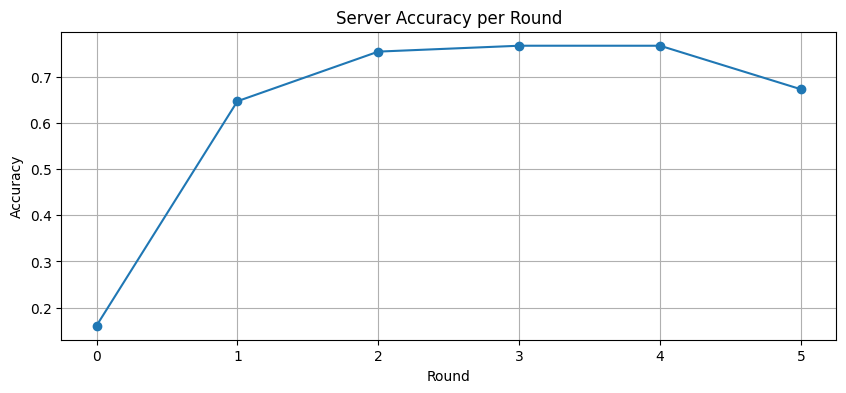

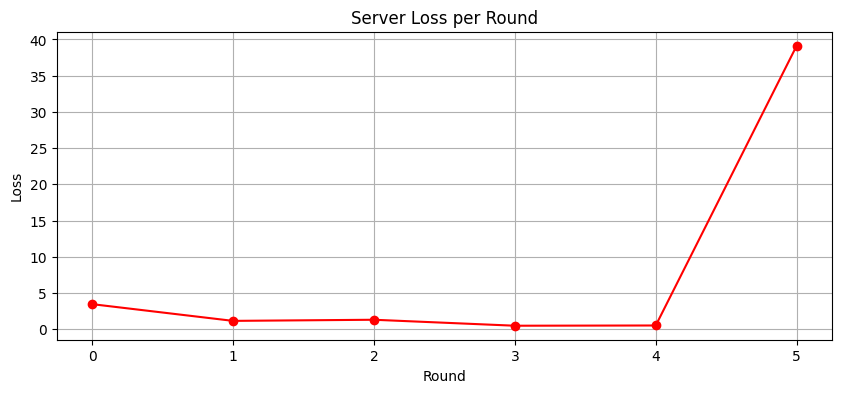

In [33]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()


	•	Trong vài vòng đầu, FedAvg vẫn có thể học ổn định dù có poisoning (accuracy cao, loss thấp).
	•	Nhưng khi số update độc hại tích tụ, mô hình toàn cục bị kéo lệch mạnh → loss tăng đột biến, accuracy giảm.


```
2025-09-10 08:34:49.069707 - 0 : Server evaluation complete - Accuracy: 0.1608, Loss: 3.4486
2025-09-10 08:38:44.170048 - 1 : Server evaluation complete - Accuracy: 0.6468, Loss: 1.1395
2025-09-10 08:42:15.397821 - 2 : Server evaluation complete - Accuracy: 0.7543, Loss: 1.2945
2025-09-10 08:45:13.304452 - 3 : Server evaluation complete - Accuracy: 0.7670, Loss: 0.4704
2025-09-10 08:48:48.090541 - 4 : Server evaluation complete - Accuracy: 0.7669, Loss: 0.5032
2025-09-10 08:51:51.093454 - 5 : Server evaluation complete - Accuracy: 0.6726, Loss: 39.1343

```

